# Poroelasticity

We consider quasi-static linear Biot-equations.

Find $\mathbf{u}, p$ s.t
\begin{align}
- \operatorname{div}( \mathbf{K} \nabla p ) &= 0, \\
- \operatorname{div} \left( \sigma( \mathbf{u} ) - \alpha p I \right) &= 0,
\end{align}
where
\begin{align}
\sigma( \mathbf{u} ) &= \lambda \operatorname{tr} \epsilon ( \mathbf{u} ) I + 2 \mu \epsilon( \mathbf{u} ), \\
\epsilon( \mathbf{u} ) &= \frac{1}{2} \left( \nabla \mathbf{u} + (\nabla \mathbf{u})^T \right) \\
\end{align}
and $\lambda, \mu > 0$ are the Lamé constants, $\alpha$ the Biot-Willis constant and $\mathbf{K}$ the permeability.

We include an interface $\Gamma$ with a fixed pressure $p_\Gamma$ and impose interior boundary conditions
\begin{align}
p &= p_\Gamma, \\
\left( \sigma(\mathbf{u}) - \alpha p I \right) \cdot \mathbf{n} &= -p_\Gamma \mathbf{n}.
\end{align}

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

file = "grids/tjunction.msh"

gridView = mmesh((reader.gmsh, file), 2)
igridView = gridView.hierarchicalGrid.interfaceGrid

In [2]:
from ufl import *
from dune.ufl import Constant

lamb    = Constant( 0.5, name="lambda")
mu      = Constant(   1, name="mu")
alpha   = Constant(   1, name="alpha")
p_gamma = Constant( 1e2, name="p_gamma")
K       = as_matrix([[1e-3, 0], [0, 1e-6]])

epsilon = lambda u: 0.5 * (nabla_grad(u) + nabla_grad(u).T)
sigma   = lambda u: lamb * div(u) * Identity(2) + 2 * mu * epsilon(u)

In [3]:
from dune.fem.space import dglagrange

space = dglagrange(gridView, dimRange=3, order=1)

trial = TrialFunction(space)
test = TestFunction(space)

p,  ux,  uy  = split(trial)
pp, uux, uuy = split(test)

u  = as_vector([ux,  uy ])
uu = as_vector([uux, uuy])

x = SpatialCoordinate(space)
n = FacetNormal(space)
h = FacetArea(space)

## Interior Penalty Discontinuous Galerkin (IPDG) Scheme

In [4]:
from dune.mmesh import skeleton, trace, interfaceIndicator

I = interfaceIndicator(igridView)
beta = Constant(1e3, name="beta")


# Pressure
a  = inner(K * grad(p), grad(pp)) * dx

a += beta / h * inner(jump(p), jump(pp)) * (1-I)*dS
a -= inner(avg(K*grad(p )), n('+')) * jump(pp) * (1-I)*dS
a -= inner(avg(K*grad(pp)), n('+')) * jump(p ) * (1-I)*dS

a += beta / h * (p - 0) * pp * ds
a -= inner(K*grad(p ), n) * pp * ds
a -= inner(K*grad(pp), n) * (p - 0)  * ds

# Pressure is continuous at the interface
a += beta / h * (p('+') - p_gamma) * pp('+') * I*dS
a -= inner(K*grad( p('+')), n('+')) * pp('+') * I*dS
a -= inner(K*grad(pp('+')), n('+')) * (p('+') - p_gamma) * I*dS

a += beta / h * (p('-') - p_gamma) * pp('-') * I*dS
a -= inner(K*grad( p('-')), n('-')) * pp('-') * I*dS
a -= inner(K*grad(pp('-')), n('-')) * (p('-') - p_gamma) * I*dS



# Displacement
a += inner(sigma(u), epsilon(uu)) * dx
a += alpha * inner(grad(p), uu) * dx

a += beta / h * inner(jump(u), jump(uu)) * (1-I)*dS
a -= dot(dot(avg(sigma(u )), n('+')), jump(uu)) * (1-I)*dS
a -= dot(dot(avg(sigma(uu)), n('+')), jump(u )) * (1-I)*dS

a += beta / h * inner(u - as_vector([0,0]), uu) * ds
a -= dot(dot(sigma(u ), n), uu) * ds
a -= dot(dot(sigma(uu), n), u - as_vector([0,0])) * ds

# Normal stress is -p at the interface
a -= -p_gamma * inner(uu('+'), n('+')) * I*dS
a -= -p_gamma * inner(uu('-'), n('-')) * I*dS

In [5]:
from dune.fem.scheme import galerkin
scheme = galerkin([a == 0], solver=("suitesparse", "umfpack"))
solution = space.interpolate([0,0,0], name="solution")
res = scheme.solve(target=solution)

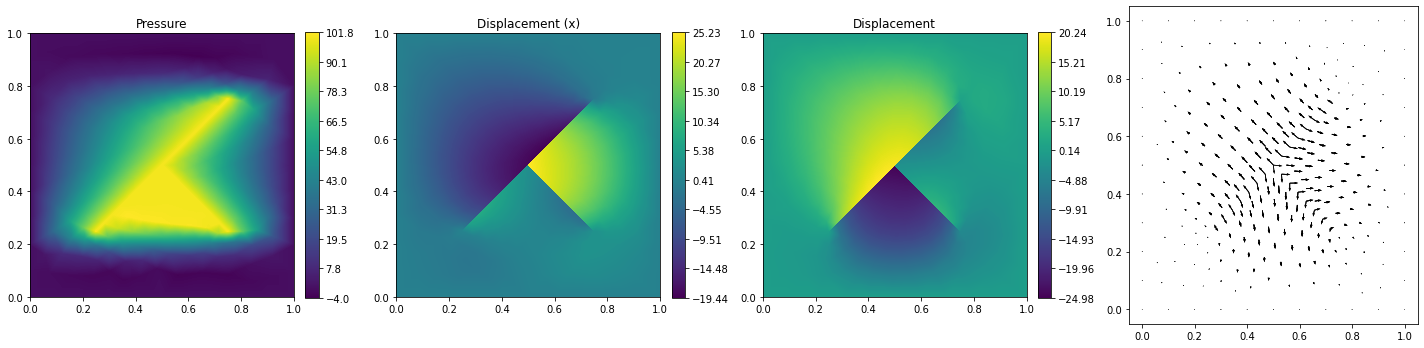

In [6]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].set_title('Pressure')
plot(solution[0], figure=(fig, axs[0]), gridLines=None)
axs[1].set_title('Displacement (x)')
plot(solution[1], figure=(fig, axs[1]), gridLines=None)
axs[2].set_title('Displacement (y)')
plot(solution[2], figure=(fig, axs[2]), gridLines=None)
axs[2].set_title('Displacement')
plot(solution, vectors=[1,2], figure=(fig, axs[3]), gridLines=None)